# Producing the main figure for the paper

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [2]:
gaia_mc0 = pd.read_csv("gaia_mc.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars
m &= (gaia_mc1.color_teffs.values < 5000) * (3500 < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

gaia_mc = gaia_mc1.iloc[m]

(29727, 155)
(10544, 155) no visual binaries or subgiants
(10405, 155) no large vb uncertainties
(10274, 155) no faint stars
(9684, 155) no rapid rotators
(6820, 155) no hot or cold stars


Make cuts in log age.

In [13]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(3.5), 7)
mid_age_bins = age_bins[:-1] + .5*np.diff(age_bins)
age_masks = select_stars(gaia_mc, age_bins, "age")

Set up color values.

In [14]:
cmap = plt.cm.get_cmap('viridis_r')
vmin, vmax = np.log10(1e9*min(mid_age_bins)), np.log10(1e9*max(mid_age_bins))
log_agebins = np.log10(age_bins*1e9)
age_midbin = np.diff(log_agebins)*.5 + log_agebins[:-1]
color_values = (age_midbin - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format data.

In [7]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (5100, 3100)

tbins = np.linspace(min(x), max(x), 10)
ds, derrs = [np.zeros((len(age_bins), len(tbins[:-1]))) for i in range(2)]

In [8]:
def betterstep_scatter(bins, y, c, label, **kwargs):
    new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
    new_y = [a for row in zip(y, y) for a in row]
    ax = kwargs.pop("ax", plt.gca())
    ax.plot(new_x, new_y, color=c, lw=2, rasterized=True, label=label)

Make main figure

  0%|          | 0/1000 [00:00<?, ?it/s]

niter =  3 7 stars removed kurtosis =  0.16494527576110318
niter =  2 3 stars removed kurtosis =  -0.3206058375939782
niter =  2 5 stars removed kurtosis =  -0.44023564009195715
niter =  2 4 stars removed kurtosis =  -0.03953171441661585
niter =  3 13 stars removed kurtosis =  0.11288262025288498
niter =  3 14 stars removed kurtosis =  0.048021436188922184
niter =  3 7 stars removed kurtosis =  0.16494527576110318


  7%|▋         | 70/1000 [00:00<00:01, 692.62it/s]

niter =  2 3 stars removed kurtosis =  -0.3206058375939782


  7%|▋         | 67/1000 [00:00<00:01, 662.26it/s]

niter =  2 5 stars removed kurtosis =  -0.44023564009195715


  6%|▋         | 65/1000 [00:00<00:01, 638.61it/s]

niter =  2 4 stars removed kurtosis =  -0.03953171441661585


 12%|█▏        | 123/1000 [00:00<00:01, 609.84it/s]

niter =  3 13 stars removed kurtosis =  0.11288262025288498


 12%|█▏        | 123/1000 [00:00<00:01, 607.24it/s]

niter =  3 14 stars removed kurtosis =  0.048021436188922184


100%|██████████| 1000/1000 [00:01<00:00, 641.58it/s]


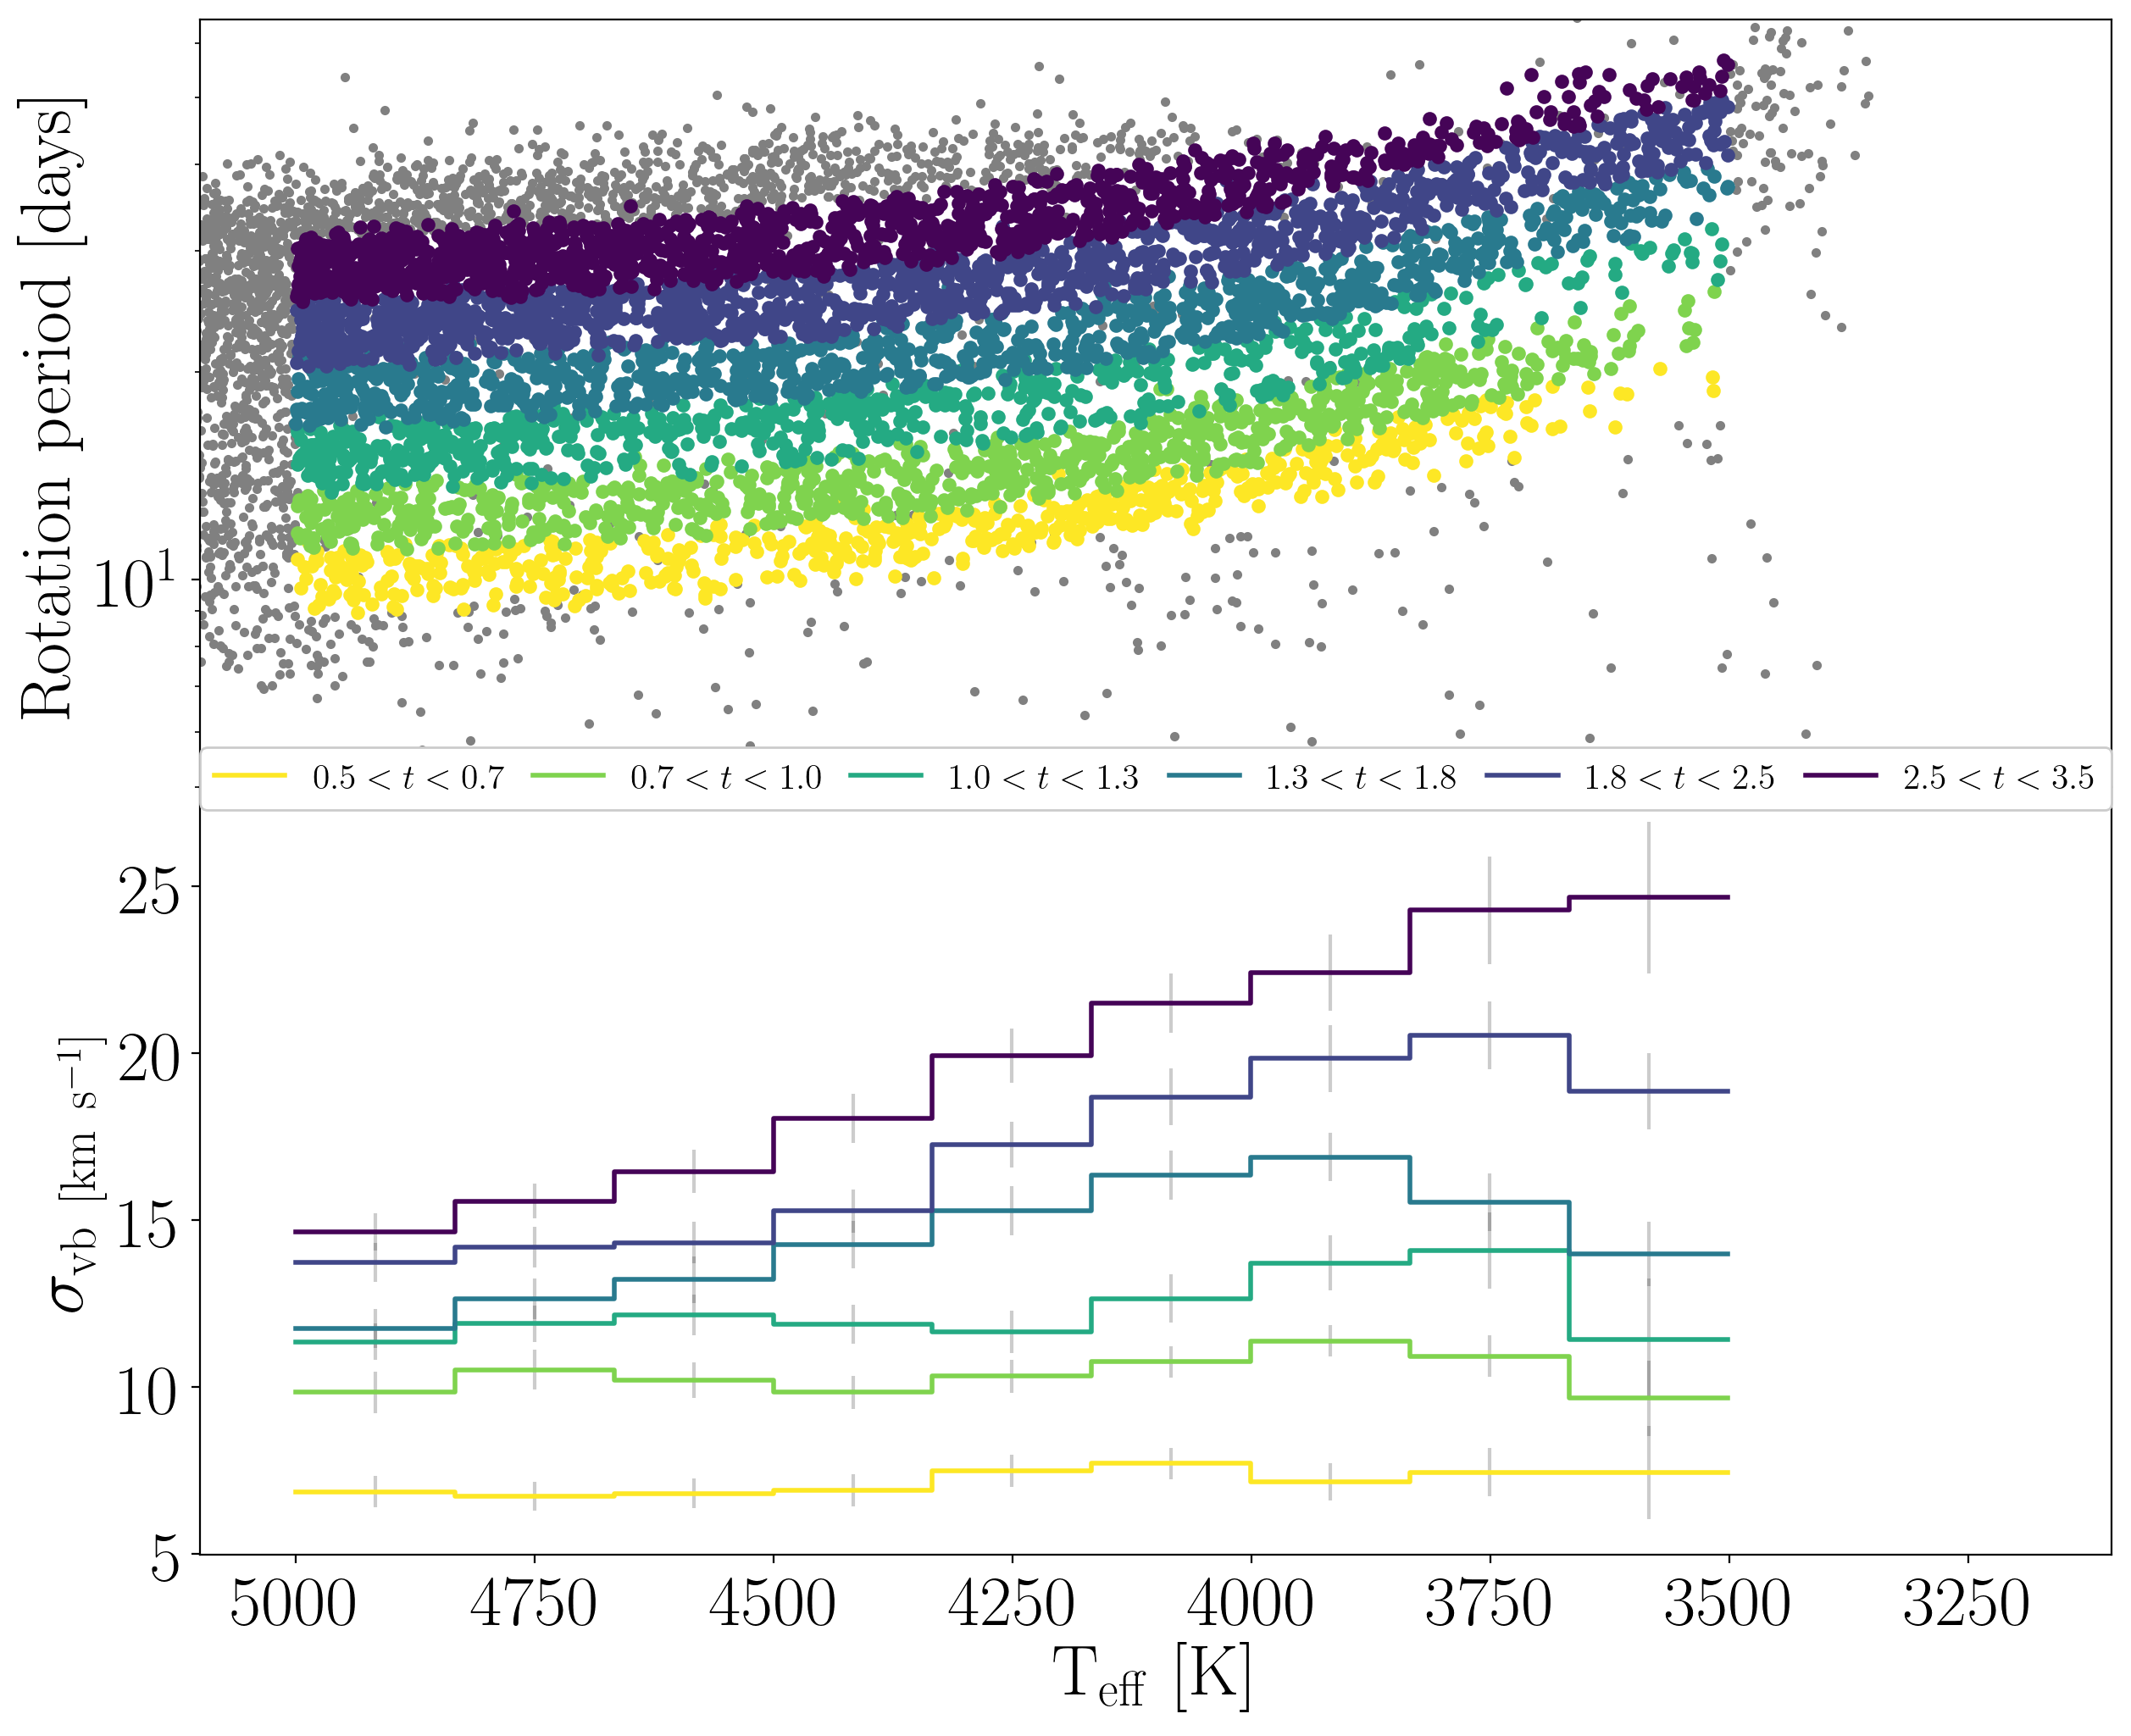

In [11]:
fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter.
ax1.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# Top panel: period-teff relations
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
                      vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=25,
                      label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    
# Add the sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(5, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped, xerr[m][clipping_mask], 
                                     verr[m][clipping_mask],
                                     tbins, 1000, method="std")
    ds[i, :] = d
    derrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     derrs[i, :] = derr
    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.2,
                 rasterized=True)
    
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb~[km~s^{-1}]}$")
ax2.set_xlim(xlim)
plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)

plt.subplots_adjust(hspace=0, right=0.83)

Now make cuts in rotation period.

In [12]:
period_bins = 10**np.linspace(np.log10(10), np.log10(50), 7)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Set the color scale.

In [15]:
vmin, vmax = min(mid_period_bins), max(mid_period_bins)
color_values = (mid_period_bins - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format the data.

In [17]:
y = gaia_mc.Prot.values

In [ ]:
fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter
ax1.plot(gaia_mc.color_teffs, gaia_mc.Prot, ".", color=".5", rasterized=True, zorder=0)

# Colored sections in period-color space
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
                      vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=25,
                      label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    
# Sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(7, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

# Velocity-teff plot
ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped,
                                     xerr[m][clipping_mask], verr[m][clipping_mask],
                            tbins, 1000, method="std")
    derr = err_on_sample_std_dev(d, len(x[m][clipping_mask]))

    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.5,
                 rasterized=True)

plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb}$")
ax2.set_xlim(xlim)
plt.subplots_adjust(hspace=0)  # , right=0.83)
plt.savefig("paper/period_cut.pdf")

  0%|          | 0/1000 [00:00<?, ?it/s]

niter =  3 6 stars removed kurtosis =  0.1300914815500689
niter =  3 4 stars removed kurtosis =  -0.2581486774378581
niter =  2 9 stars removed kurtosis =  -0.20237706924829624
niter =  3 8 stars removed kurtosis =  -0.022274565181087613
niter =  2 6 stars removed kurtosis =  -0.043403247864446826
niter =  4 9 stars removed kurtosis =  -0.06726783691655402
niter =  3 6 stars removed kurtosis =  0.1300914815500689


/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 13%|█▎        | 134/1000 [00:00<00:01, 665.07it/s]

niter =  3 4 stars removed kurtosis =  -0.2581486774378581


  6%|▋         | 65/1000 [00:00<00:01, 648.14it/s]

niter =  2 9 stars removed kurtosis =  -0.20237706924829624


 12%|█▏        | 120/1000 [00:00<00:01, 587.05it/s]

niter =  3 8 stars removed kurtosis =  -0.022274565181087613


  6%|▌         | 56/1000 [00:00<00:01, 555.15it/s]

niter =  2 6 stars removed kurtosis =  -0.043403247864446826


  8%|▊         | 76/1000 [00:00<00:01, 757.40it/s]

niter =  4 9 stars removed kurtosis =  -0.06726783691655402


100%|██████████| 1000/1000 [00:01<00:00, 763.43it/s]
